In [1]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 25.0 MB 1.6 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [116]:
#detects keypoints and extracts local invariant descriptors using sift method
def detectAndDescribe(image):
 descriptor = cv2.xfeatures2d.SIFT_create()
 (kps, features) = descriptor.detectAndCompute(image, None)
 kps = np.float32([kp.pt for kp in kps])
 # return a tuple of keypoints and features
 return (kps, features)

In [118]:
def descriptor_normalizer(feature_vec):
  # normalize descriptors to zero mean and unit std
  m = np.expand_dims(feature_vec.mean(axis=1), axis=1)
  s = np.expand_dims(feature_vec.std(axis=1), axis=1)
  return (feature_vec-m)/s

In [123]:
from numpy import linalg as LA
def getRawMatches_L2norm(n_featuresA, n_featuresB, numOfmatches = 2):
  raw_matches = []
  for i, source_f in enumerate(n_featuresA):
    distance_list = np.array([LA.norm(source_f-n_featuresB,axis=1),i*np.ones(len(n_featuresB)), [i for i in range(len(n_featuresB))]]).transpose()
    sd = distance_list[distance_list[:, 0].argsort()]
    raw_matches.append(sd[:numOfmatches])
  raw_matches = np.array(raw_matches)
  return raw_matches

In [124]:
def extract_best_matches(raw_matches, lowe_ratio=0.9):
  # loop over the raw matches
  matches = []
  for m in raw_matches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe's ratio test)
    if len(m) == 2 and m[0,0] < m[1,0] * lowe_ratio:
        matches.append((m[0,1], m[0,2]))

  return matches

In [142]:
def calculateHomography(ptsA, ptsB):
    #loop through correspondences and create assemble matrix
    aList = []
    for a,b in zip(ptsA, ptsB):
        p1 = np.array([a[0], a[1], 1])
        p2 = np.array([b[0], b[1], 1])
        
        a2 = [0, 0, 0, -p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2],
              p2[1] * p1[0], p2[1] * p1[1], p2[1] * p1[2]]
        
        a1 = [-p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], 0, 0, 0,
              p2[0] * p1[0], p2[0] * p1[1], p2[0] * p1[2]]
        
        aList.append(a1)
        aList.append(a2)
    
    matrixA = np.array(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8,:], (3, 3))

    #normalize and now we have h
    h = (1/h[2,2]) * h
    return h


#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(cpa, cpb, h):

    p1 = np.transpose(np.array([cpa[0], cpa[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.array([cpb[0], cpb[1], 1]))
    error = p2 - estimatep2
    return LA.norm(error)


#
#Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(ptsA, ptsB, thresh):
    maxInliers = 0
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        r_ind = np.random.randint(0,len(ptsA),4)
        r_pta = ptsA[r_ind]
        r_ptb = ptsB[r_ind]
        
        #call the homography function on those points
        h = calculateHomography(r_pta, r_ptb)
        
        status = np.zeros(ptsA.shape[0])
        inliers = 0

        for i in range(len(ptsA)):
            d = geometricDistance(ptsA[i], ptsB[i], h)
            if d < thresh:
                status[i] = 1
                inliers += 1

        if inliers > maxInliers:
            maxInliers = inliers
            finalH = h
        

        if maxInliers > (len(ptsA)*0.5):
            break
    return finalH, status

# **define main function**

In [143]:
def get_h_status(imageA, imageB):
  # extract key-points and cooresponding descriptor with SIFT algorithm
  (kpsA, featuresA) = detectAndDescribe(imageA)
  (kpsB, featuresB) = detectAndDescribe(imageB)
  # normalize image descriptors
  n_featuresA = descriptor_normalizer(featuresA)
  n_featuresB = descriptor_normalizer(featuresB)
  # get raw matches
  raw_matches = getRawMatches_L2norm(n_featuresA, n_featuresB)
  # find best matches
  matches = extract_best_matches(raw_matches, lowe_ratio=0.9)

  if len(matches) > 4:
	# construct the two sets of points
    ptsA = np.float32([kpsA[int(i)] for (i, _) in matches])
    ptsB = np.float32([kpsB[int(i)] for (_, i) in matches])
    # compute the homography between the two sets of points
    H, status = ransac(ptsA, ptsB, 5.0)
		# return the matches along with the homograpy matrix
		# and status of each matched point
    return (matches, H, status, kpsA, kpsB)
  # otherwise, no homograpy could be computed
  return None



# **test for images**

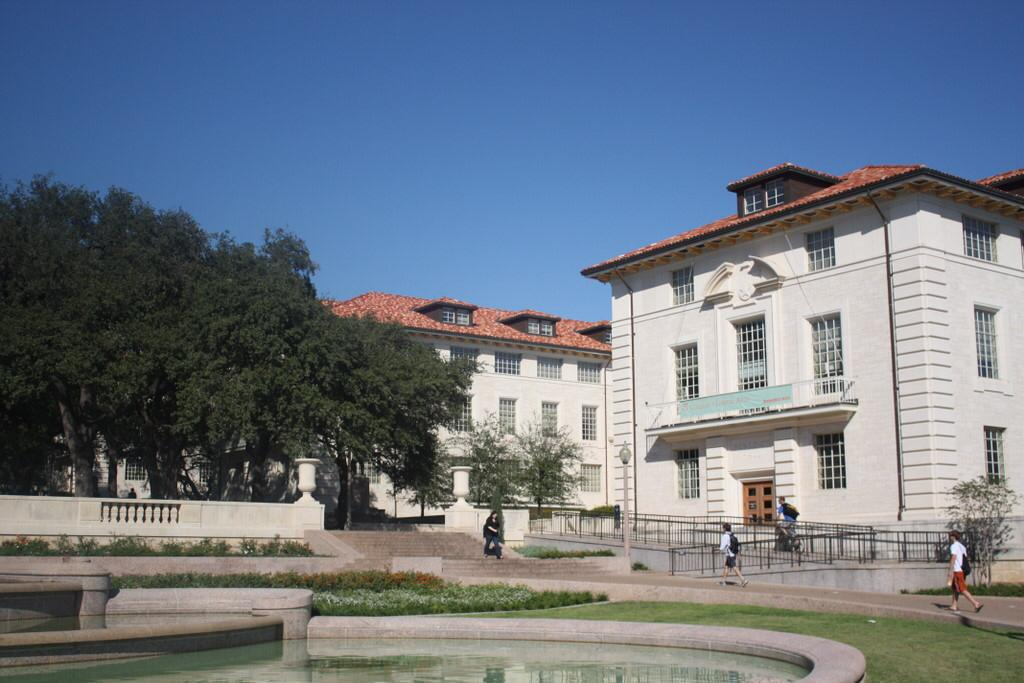

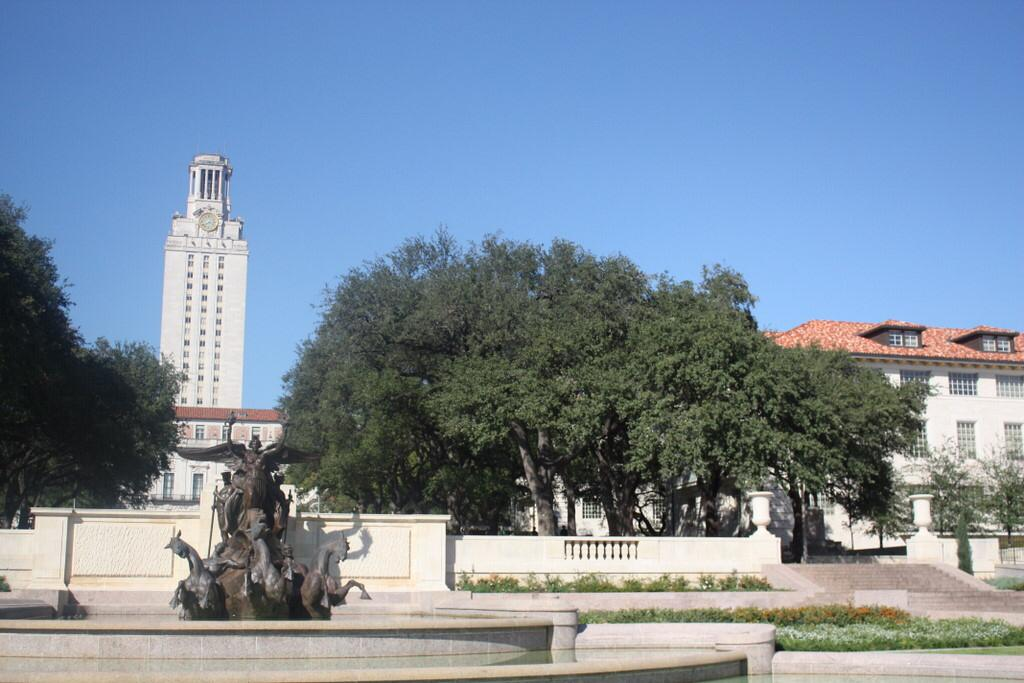

In [4]:
# read images
imageA = cv2.imread('right.jpeg')
imageB = cv2.imread('left.jpeg')
cv2_imshow(imageA)
cv2_imshow(imageB)

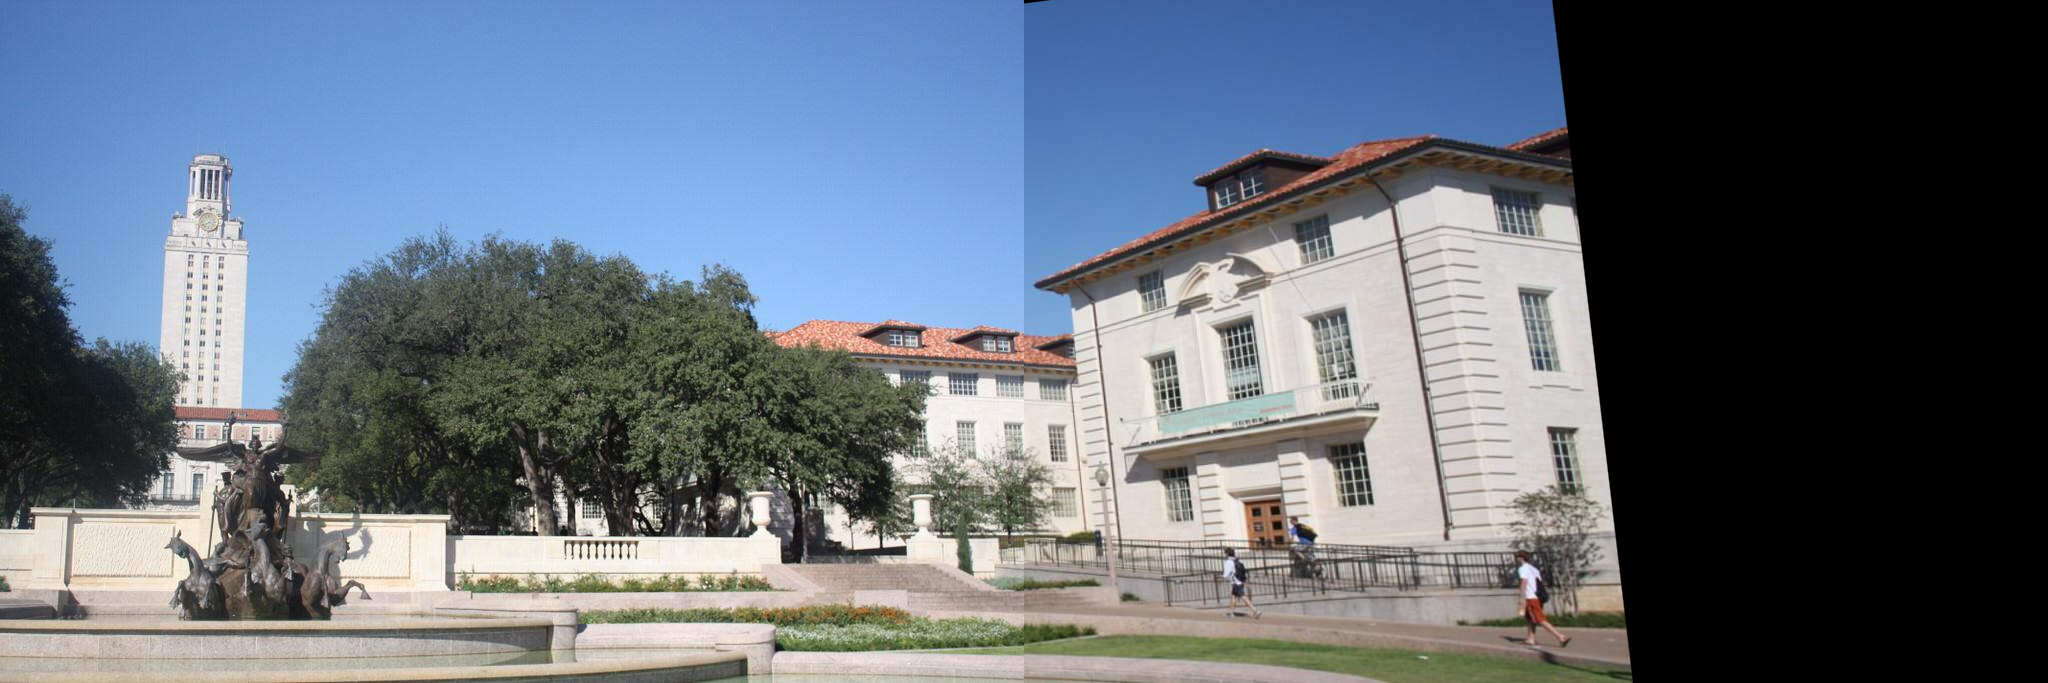

In [144]:
# match features between the two images
M = get_h_status(imageA, imageB)
# if the match is None, then there aren't enough matched
# keypoints to create a panorama
if M is None:
    print('This 2 images does not match')

# otherwise, apply a perspective warp to stitch the images together
(matches, H, status, kpsA, kpsB) = M
result = cv2.warpPerspective(imageA, finalH,
		(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

cv2_imshow(result)

In [145]:
print('number of inliers: ',len(np.where(status==1)[0]))

number of inliers:  1109


In [146]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
	# initialize the output visualization image
	(hA, wA) = imageA.shape[:2]
	(hB, wB) = imageB.shape[:2]
	vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
	vis[0:hA, 0:wA] = imageA
	vis[0:hB, wA:] = imageB
	# loop over the matches
	for ((trainIdx, queryIdx), s) in zip(matches, status):
		# only process the match if the keypoint was successfully
		# matched
		if s == 1:
			# draw the match
			ptA = (int(kpsA[int(trainIdx)][0]), int(kpsA[int(trainIdx)][1]))
			ptB = (int(kpsB[int(queryIdx)][0]) + wA, int(kpsB[int(queryIdx)][1]))
			cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
	# return the visualization
	return vis

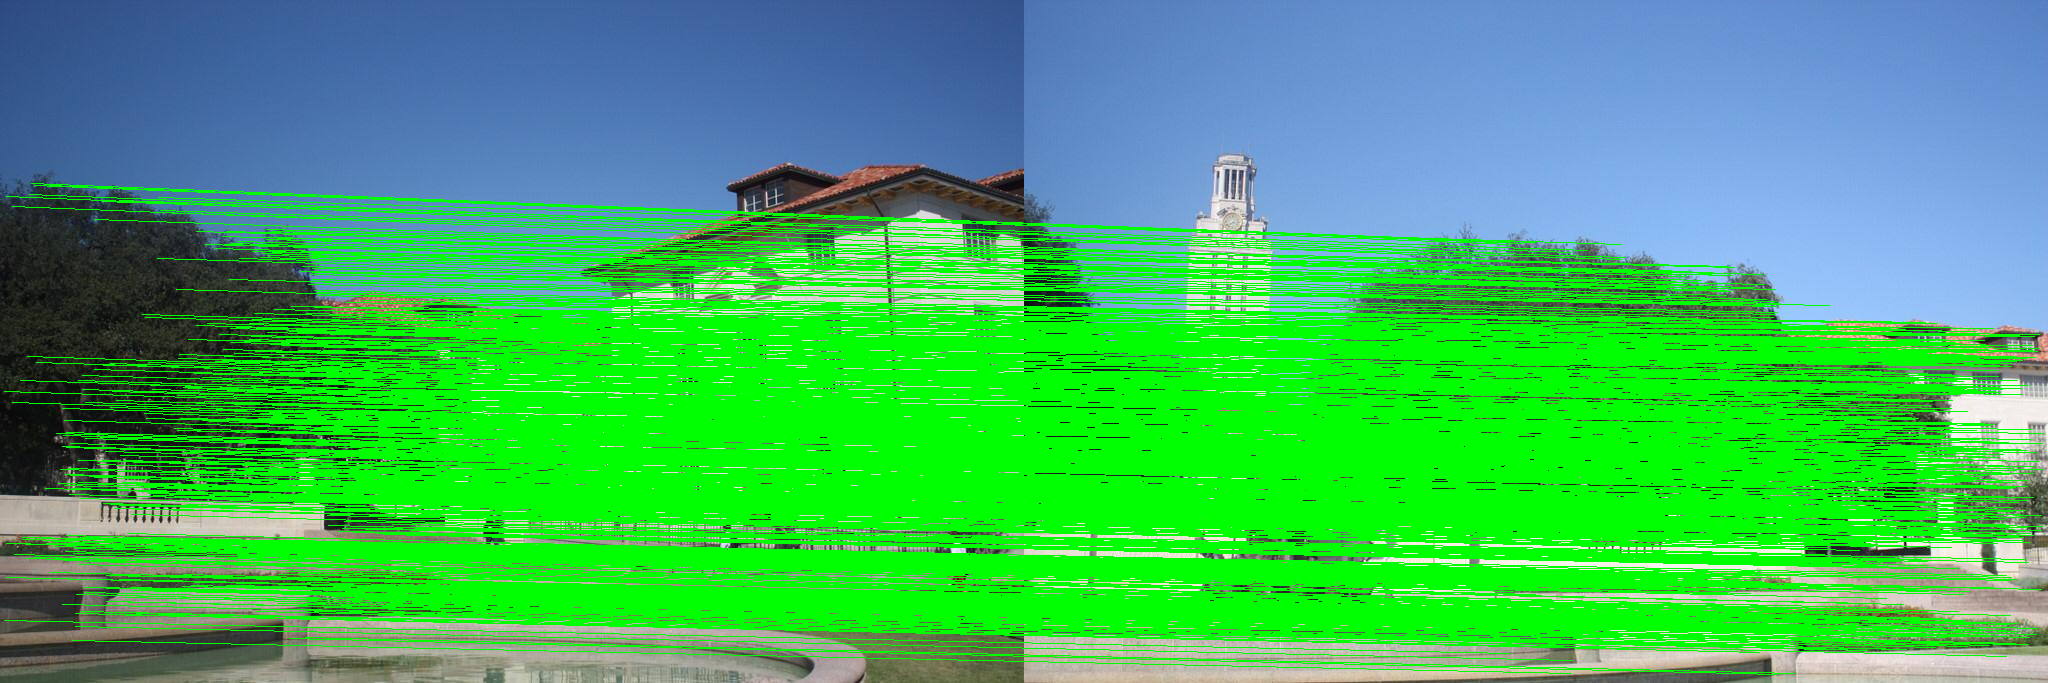

In [147]:
# check to see if the keypoint matches should be visualized
vis = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
# show the images
cv2_imshow(vis)
